In [85]:
%%HTML
# Basic styling for the notebook in vscode
<style>
    body {
        --vscode-font-family: "avenir";
        --vscode-font-weight: 500;
    }
</style>    

In [86]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_days_since_last_release_col, add_repo_age_days_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, forecast_growth

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [87]:
df = pd.read_csv('../data/github_data.csv')
df.head()

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,vim-airline,vim-airline,lean & mean status/tabline for vim that's ligh...,https://github.com/vim-airline/vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30T18:49:56Z,2024-09-21T10:52:01Z,v0.1,2013-08-09 19:12:50+00:00,1,4,85,1775,110,1775
1,vim-airline,vim-airline,lean & mean status/tabline for vim that's ligh...,https://github.com/vim-airline/vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30T18:49:56Z,2024-09-21T10:52:01Z,v0.3,2013-08-12 22:07:03+00:00,2,9,171,3551,221,3551
2,vim-airline,vim-airline,lean & mean status/tabline for vim that's ligh...,https://github.com/vim-airline/vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30T18:49:56Z,2024-09-21T10:52:01Z,v0.4,2013-08-26 17:01:52+00:00,3,13,256,5326,331,5326
3,vim-airline,vim-airline,lean & mean status/tabline for vim that's ligh...,https://github.com/vim-airline/vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30T18:49:56Z,2024-09-21T10:52:01Z,v0.5,2013-09-09 14:19:37+00:00,4,18,341,7102,441,7102
4,vim-airline,vim-airline,lean & mean status/tabline for vim that's ligh...,https://github.com/vim-airline/vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30T18:49:56Z,2024-09-21T10:52:01Z,v0.6,2013-10-10 17:59:55+00:00,6,22,426,8877,552,8877


In [88]:
# Functions Definitions
    
def provideMissingDesc(repo_name, description):
    df.loc[df['repo_name'] == repo_name, 'description'] = description

## Data Cleanup

In [89]:
print(df.shape)
print(df.describe())


(9938, 15)
       num_releases  num_open_issues  num_pull_requests      num_stars  \
count   9938.000000      9938.000000        9938.000000    9938.000000   
mean      13.326424       111.300362         946.586838    4622.926243   
std        8.608284       310.833634        3241.005609    8753.266035   
min        1.000000         0.000000           0.000000      42.000000   
25%        6.000000        10.000000          37.000000     889.250000   
50%       12.000000        33.000000         150.000000    1835.500000   
75%       20.000000        99.000000         593.000000    4663.250000   
max       30.000000      4756.000000       47863.000000  166742.000000   

          num_forks   num_watchers  
count   9938.000000    9938.000000  
mean     659.408030    4622.926243  
std     1744.519848    8753.266035  
min        0.000000      42.000000  
25%       88.000000     889.250000  
50%      222.000000    1835.500000  
75%      583.000000    4663.250000  
max    44110.000000  16674

In [90]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           9938 non-null   object
 1   repo_name          9938 non-null   object
 2   description        9907 non-null   object
 3   repo_url           9938 non-null   object
 4   topics             9097 non-null   object
 5   creation_date      9938 non-null   object
 6   update_date        9938 non-null   object
 7   release_tag        9938 non-null   object
 8   release_date       9938 non-null   object
 9   num_releases       9938 non-null   int64 
 10  num_open_issues    9938 non-null   int64 
 11  num_pull_requests  9938 non-null   int64 
 12  num_stars          9938 non-null   int64 
 13  num_forks          9938 non-null   int64 
 14  num_watchers       9938 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.1+ MB
None


There seem to be some missing values in the description and the release date / release tag columns. I will research the related repositories to try to extract some descriptions to fill up the gap.
Also I'll convert the `creation_date` and the `update_date` to datetime format.

In [91]:
df[df['description'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
1551,bilibili,ailab,NaN,https://github.com/bilibili/ailab,NaN,2021-05-07T03:03:28Z,2024-09-19T13:21:27Z,Real-CUGAN-add-low-memory-mode,2022-02-20 16:17:25+00:00,2,37,6,2798,274,2798
1553,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222040837,2022-02-22 04:17:49+00:00,1,9,17,43,4,43
1554,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222093559,2022-02-22 09:46:48+00:00,2,18,34,85,9,85
1558,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222230032,2022-02-22 23:07:52+00:00,3,26,52,128,13,128
1559,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223080646,2022-02-23 08:13:31+00:00,4,35,69,170,18,170
1560,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223141509,2022-02-23 14:24:39+00:00,5,44,86,213,22,213
1561,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223191115,2022-02-23 19:20:00+00:00,6,53,103,256,27,256
1562,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220224141935,2022-02-24 14:26:48+00:00,7,62,120,298,31,298
1566,bilibili,ailab,NaN,https://github.com/bilibili/ailab,NaN,2021-05-07T03:03:28Z,2024-09-19T13:21:27Z,Real-CUGAN-add-faster-low-memory-mode,2022-02-27 06:55:52+00:00,3,74,13,5595,549,5595
1567,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220227134704,2022-02-27 13:56:21+00:00,8,70,138,341,36,341


In [92]:
# Fix the missing description by copying description form the repo's README file

provideMissingDesc("ml-ferret", "An End-to-End MLLM that Accept Any-Form Referring and Ground Anything in Response.")
provideMissingDesc("ailab", "Real Cascade U-Nets for Anime Image Super Resolution")
provideMissingDesc("MTProxy", "Simple MT-Proto proxy")
provideMissingDesc("MLOps-Basics", "The goal of the series is to understand the basics of MLOps like model building, monitoring, configurations, testing, packaging, deployment, cicd, etc")
provideMissingDesc("gpt-llm-trainer", "The goal of this project is to explore an experimental new pipeline to train a high-performing task-specific model. We try to abstract away all the complexity, so it's as easy as possible to go from idea -> performant fully-trained model.")
provideMissingDesc("ml-mgie", "Guiding Instruction-based Image Editing via Multimodal Large Language Models")
provideMissingDesc("NLPIR", "NLPIR stores relevant files of the NLPIR big data semantic enhanced analysis platform")
provideMissingDesc("Roadmap-To-Learn-Generative-AI-In-2024", "Roadmap To Learn Generative AI In 2024")
provideMissingDesc("crewAI-examples", "crewAI is designed to facilitate the collaboration of role-playing AI agents. This is a collection of examples of different ways to use the crewAI framework to automate the processes")
provideMissingDesc("LLM-Agent-Survey", "A Survey on LLM-based Autonomous Agents")
provideMissingDesc("airsonic-advanced", "Airsonic-Advanced is a more modern implementation of the Airsonic fork with several key performance and feature enhancements. It adds and supersedes several features in Airsonic.")
provideMissingDesc("ai-component-generator", "This project generates almost any UI components with OpenAI's ChatGPT and allows you to copy the html code")

In [93]:
print(df['description'].isna().sum())

0


In [94]:
df[df['release_date'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers


Since the release_date feature is a very relevant feature for our model we'll drop rows that don't have a release_date.

In [95]:
df = df.dropna(subset=['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           9938 non-null   object
 1   repo_name          9938 non-null   object
 2   description        9938 non-null   object
 3   repo_url           9938 non-null   object
 4   topics             9097 non-null   object
 5   creation_date      9938 non-null   object
 6   update_date        9938 non-null   object
 7   release_tag        9938 non-null   object
 8   release_date       9938 non-null   object
 9   num_releases       9938 non-null   int64 
 10  num_open_issues    9938 non-null   int64 
 11  num_pull_requests  9938 non-null   int64 
 12  num_stars          9938 non-null   int64 
 13  num_forks          9938 non-null   int64 
 14  num_watchers       9938 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [96]:
num_na_values_per_repo = df.groupby('repo_name')['topics'].apply(lambda x: x.isna().sum())
num_na_values_per_repo = num_na_values_per_repo[num_na_values_per_repo > 0]
print(f"Number of NaN values in 'topics' column: {num_na_values_per_repo.head(50)}")

Number of NaN values in 'topics' column: repo_name
AI                              1
AI-Writer                       7
AI-on-the-edge-device          29
AI0x0.com                      29
AITemplate                      1
AiNiee                         29
AirGuard                       17
AntiFraudChatBot                1
Arcade-Learning-Environment    14
Auto-Synced-Translated-Dubs    23
DevOpsGPT                       1
DouZero_For_HappyDouDiZhu       1
FlagAI                         29
GameAISDK                       1
KMS_VL_ALL_AIO                 20
KoboldAI-Client                 4
Linly-Talker                    1
MoneyPrinterPlus               10
Open-Sora-Plan                  2
ParlAI                         22
PhoenixGo                       4
PraisonAI                      29
RealChar                       29
SalesGPT                       10
SecureAI-Tools                  4
VideoLingo                     18
Vitis-AI                       12
agent-zero                     

In [97]:
# Save a backup copy of the repo and topic with NaN value so that later I can verify the populated values
# df[df['topics'].isna()][['repo_name', 'topics']].drop_duplicates(subset=['repo_name']).reset_index(drop=True)

na_unique_indices = df[df['topics'].isna()].drop_duplicates(subset=['repo_name']).index

na_unique_indices

Index([  14,   23,   36,   54,   59,   64,  104,  123,  164,  246,  332,  391,
        607,  618,  655,  684,  708,  709,  738,  767,  775, 1028, 1126, 1240,
       1256, 1280, 1346, 1395, 1424, 1503, 1551, 1553, 1783, 2052, 2081, 2142,
       2264, 2383, 2472, 2542, 2596, 2643, 3013, 3174, 3600, 3661, 3765, 3813,
       4033, 4267, 4727, 4967, 5152, 5155, 5283, 5508, 5714, 6086, 6548, 6609,
       6775, 7109, 7154, 7577, 7725, 7785, 7942, 8002, 8085, 8225, 8683, 8688,
       9177, 9314],
      dtype='int64')

In [98]:
len(df.topics.unique())

511

In [99]:
# Populate the missing topics with predefined values using the transformer library with facebook/bart-large-mnli model

from transformers import pipeline # pip install transformers

# NLP - Natural Language Processing
# NLG - Natural Language Generation
# MT - Machine Translation
# ML - Machine Learning
# MML - Multi-Modal Learning
# RL - Reinforcement Learning
# ASR - Automatic Speech Recognition
# TTS - Text-to-Speech
# RPA - Robotic Process Automation
# IR - Information Retrieval
# DL - Deep Learning
# OCR - Optical Character Recognition


classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate topics
candidate_topics = ["NLP", "NLG", "MT", "ML", "MML", "LLM", "RL", "ASR", "TTS", "RPA", "IR", "DL", "OCR", "python", "gpt"]

# Drop duplicates to get unique 'repo_name' and 'topics' combinations
unique_topics = df.drop_duplicates(subset=['repo_name', 'topics']).reset_index(drop=True)

# Apply classification only to rows where 'topics' is NaN
def classify_topic(row):
    if pd.isna(row['topics']):
        description = row['description'] if pd.notna(row['description']) else "No description available"
        candidate_topics_lower = [topic.lower() for topic in candidate_topics]
        return classifier(description, candidate_topics_lower)['labels'][0]
    else:
        return row['topics']

unique_topics['topics'] = unique_topics.apply(classify_topic, axis=1) # type: ignore

# Merge the updated topics back into the original DataFrame
df = pd.merge(df, unique_topics[['repo_name', 'topics']], 
            on=['repo_name'], how='left', suffixes=('', '_new'))

# Update the 'topics' column in the original DataFrame
df['topics'] = df['topics_new'].combine_first(df['topics'])

# Drop the helper column after merging
df.drop(columns=['topics_new'], inplace=True)

# Estimated 2m 11.4s

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [100]:
# Verify the populated NaN values
print("\nRows with NaN 'topics' before filling (unique per repo_name):")
print(df.loc[na_unique_indices[:-2]]['topics'].head(50))


Rows with NaN 'topics' before filling (unique per repo_name):
14                                                 python
23                                                    asr
36                                                    ocr
54                                                    tts
59                                                    asr
64                                                    mml
104                                                   gpt
123                                                    ir
164                                                    dl
246                                                   asr
332     kubernetes, resource-management, scheduling, m...
391     unit-testing, test-anything-protocol, browsers...
607     java, magic, game, mtg, magic-the-gathering, g...
618     docker-airflow, airflow, docker, scheduler, wo...
655     java, magic, game, mtg, magic-the-gathering, g...
684     blockchain, scalability, csharp, dotnet-core, ...
708     a

In [101]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           10022 non-null  object
 1   repo_name          10022 non-null  object
 2   description        10022 non-null  object
 3   repo_url           10022 non-null  object
 4   topics             10022 non-null  object
 5   creation_date      10022 non-null  object
 6   update_date        10022 non-null  object
 7   release_tag        10022 non-null  object
 8   release_date       10022 non-null  object
 9   num_releases       10022 non-null  int64 
 10  num_open_issues    10022 non-null  int64 
 11  num_pull_requests  10022 non-null  int64 
 12  num_stars          10022 non-null  int64 
 13  num_forks          10022 non-null  int64 
 14  num_watchers       10022 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 1.1+ MB
None


In [102]:
df['creation_date'] = pd.to_datetime(df['creation_date'], utc=True)
df['update_date'] = pd.to_datetime(df['update_date'], utc=True)
df['release_date'] = pd.to_datetime(df['release_date'], utc=True)

In [103]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   org_name           10022 non-null  object             
 1   repo_name          10022 non-null  object             
 2   description        10022 non-null  object             
 3   repo_url           10022 non-null  object             
 4   topics             10022 non-null  object             
 5   creation_date      10022 non-null  datetime64[ns, UTC]
 6   update_date        10022 non-null  datetime64[ns, UTC]
 7   release_tag        10022 non-null  object             
 8   release_date       10022 non-null  datetime64[ns, UTC]
 9   num_releases       10022 non-null  int64              
 10  num_open_issues    10022 non-null  int64              
 11  num_pull_requests  10022 non-null  int64              
 12  num_stars          10022 non-null  int64      

## EDA

In [104]:
# How many unique orgs are there?

print(f"{len(df.org_name.unique())} unique orgs")
print("-"*100)
print(df.org_name.unique()[:20],'...')

522 unique orgs
----------------------------------------------------------------------------------------------------
['vim-airline' 'aio-libs-abandoned' 'aio-libs' 'stephen' 'wit-ai'
 'openairplay' 'bwapi' 'aimacode' 'lrsjng' 'freeciv' 'opencog'
 'Farama-Foundation' 'recastnavigation' 'Kitt-AI' 'microsoft' 'puckel'
 'layabox' 'snorkel-team' 'aisingapore' 'Tencent'] ...


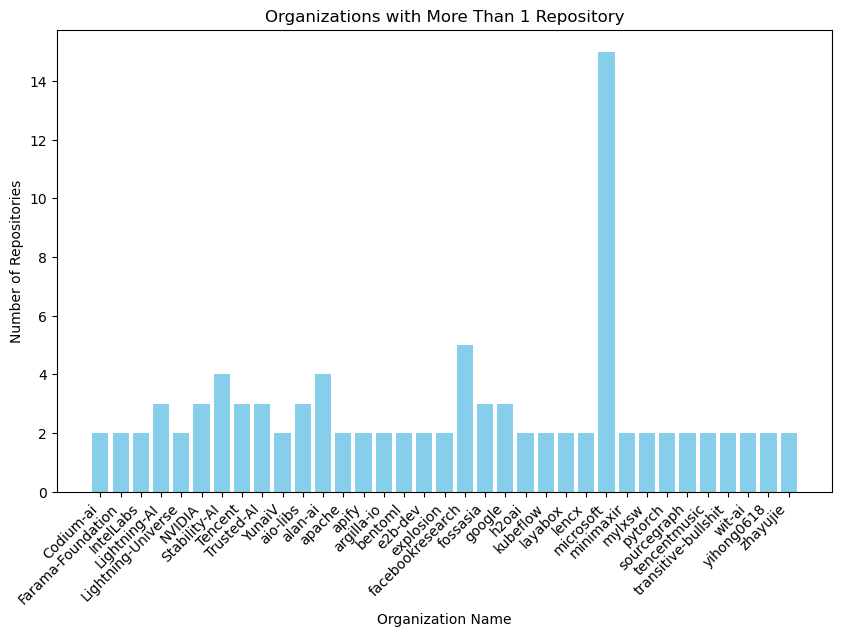

In [105]:
# Are there orgs that have multiple repos?

org_repo_count = df.groupby('org_name')['repo_name'].nunique().reset_index()
org_repo_count.columns = ['org_name', 'num_repos']
orgs_with_multiple_repos = org_repo_count[org_repo_count['num_repos'] > 1]

# Plot orgs that have more than one repos
plt.figure(figsize=(10, 6)) 
plt.bar(orgs_with_multiple_repos['org_name'], orgs_with_multiple_repos['num_repos'], color='skyblue')
plt.xlabel('Organization Name')
plt.ylabel('Number of Repositories')
plt.title('Organizations with More Than 1 Repository')
plt.xticks(rotation=45, ha='right')
plt.show()

In [106]:
# Which repos have the highest number of open issues?

open_pull_requests_per_repo = df.groupby(['creation_date', 'update_date', 'org_name', 'repo_name', 'num_pull_requests'])['num_open_issues'].sum().reset_index()
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo.sort_values(by='num_open_issues', ascending=False)
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo_sorted.reset_index(drop=True)

open_pull_requests_per_repo_sorted.head(20)

,creation_date,update_date,org_name,repo_name,num_pull_requests,num_open_issues
0,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,42294,4756
1,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,40836,4592
2,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,37109,4580
3,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,39377,4428
4,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,35829,4422
5,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,34550,4264
6,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,37919,4264
7,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,33270,4106
8,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,36460,4100
9,2016-10-25 19:38:30+00:00,2024-09-22 01:38:02+00:00,ray-project,ray,29033,4038


In [107]:
# How many unique topics are there

print("Number of unique labels:", len(df.topics))
print("-"*100)
print("Unique labels:", list(df.topics)[:20])


Number of unique labels: 10022
----------------------------------------------------------------------------------------------------
Unique labels: ['vim-airline, statusline, tabline, vim, vim-plugin', 'vim-airline, statusline, tabline, vim, vim-plugin', 'vim-airline, statusline, tabline, vim, vim-plugin', 'vim-airline, statusline, tabline, vim, vim-plugin', 'vim-airline, statusline, tabline, vim, vim-plugin', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberf

Top Ten Recurrent Topics:
topics_split
ai                         5142
llm                        2244
python                     2197
machine-learning           2099
openai                     1845
chatgpt                    1798
deep-learning              1277
artificial-intelligence    1179
gpt                        1041
gpt-4                      1009
pytorch                     867
data-science                787
rag                         730
chatbot                     713
llmops                      621
ml                          620
tensorflow                  603
hacktoberfest               601
generative-ai               585
mlops                       567
Name: count, dtype: int64


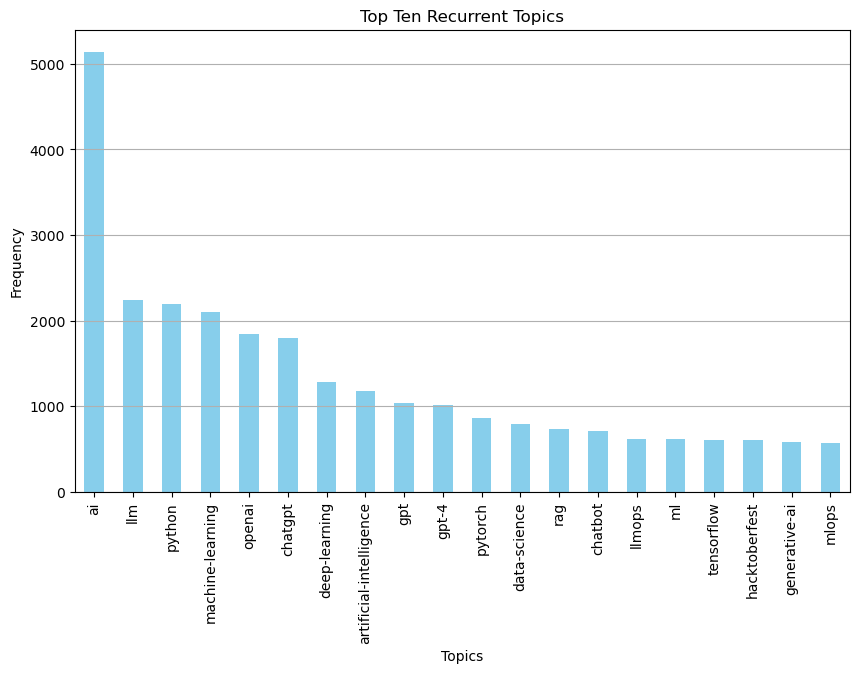

In [108]:
# What are the most recurrent topics 

topics_count_df = df.copy()

# Split the topics column by commas
topics_count_df['topics_split'] = topics_count_df['topics'].str.split(', ')

# Explode the list of topics into individual rows
df_exploded = topics_count_df.explode('topics_split')

# Count the frequency of each topic
topic_counts = df_exploded['topics_split'].value_counts()

# Get the top ten recurrent topics
top_topics = topic_counts.head(20)

# Display the top ten topics
print("Top Ten Recurrent Topics:")
print(top_topics)

# Visualize the top ten topics
plt.figure(figsize=(10, 6))
top_topics.plot(kind='bar', color='skyblue')
plt.title('Top Ten Recurrent Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

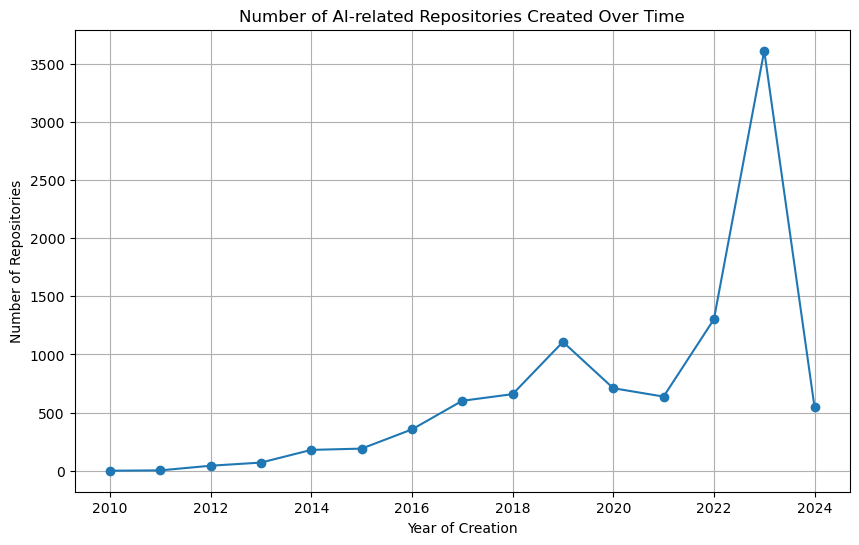

In [109]:
# Visualizing the progression of AI-related repos creation
df_creation = df.copy()
df_creation['creation_date'] = pd.to_datetime(df['creation_date'])

# Sort the DataFrame by 'creation_date' in ascending order
df_sorted = df_creation.sort_values(by='creation_date')

# Group by year see a trend over time
df_sorted['creation_year'] = df_sorted['creation_date'].dt.year
df_grouped = df_sorted.groupby('creation_year').size().reset_index(name='repo_count')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['creation_year'], df_grouped['repo_count'], marker='o')
plt.title('Number of AI-related Repositories Created Over Time')
plt.xlabel('Year of Creation')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

                     count       mean       std  min   25%   50%    75%   max
repo_name                                                                    
AElf                  29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
AGiXT                 29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
AI                     1.0   2.000000       NaN  2.0  2.00   2.0   2.00   2.0
AI-Blocks             10.0   6.100000  3.478505  1.0  3.25   6.5   8.75  11.0
AI-Lossless-Zoomer     1.0   2.000000       NaN  2.0  2.00   2.0   2.00   2.0
...                    ...        ...       ...  ...   ...   ...    ...   ...
yomo                  29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
yudao-cloud           13.0   7.538462  4.351540  1.0  4.00   8.0  11.00  14.0
yudao-ui-admin-vue3   10.0   6.100000  3.478505  1.0  3.25   6.5   8.75  11.0
zenml                 29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
zep                   29.0  15.517241  8.958718  1.0  8.00  16.0

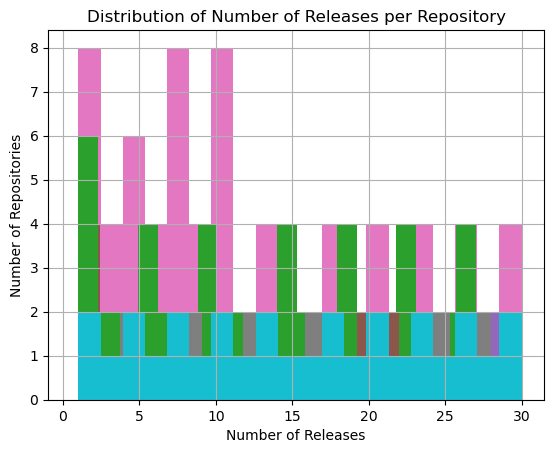

In [110]:
# How many releases are there per repo?

release_counts = df.groupby('repo_name')['num_releases']
print(release_counts.describe()) 
release_counts.hist(bins=20)
plt.xlabel('Number of Releases')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Number of Releases per Repository')
plt.show()

## Feature Engineering & Per-processing

In [111]:
df_main = df.copy()

In [112]:
columns_to_drop = ['description', 'release_tag', 'repo_url', 'update_date']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
if columns_to_drop:
    df_main.drop(columns=columns_to_drop, inplace=True)

I want to create a new `growth_score` dependent variable which will be based on `num_stars` + `num_forks` + `num_pull_requests`
but first I need to scale those values because they are very different from each other.

In [113]:
df_main= add_growth_score_based_on_main_features(df_main)

df_main.head()

,org_name,repo_name,topics,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score
0,vim-airline,vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30 18:49:56+00:00,2013-08-09 19:12:50+00:00,1,4,85,1775,110,1775,0.025903
1,vim-airline,vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30 18:49:56+00:00,2013-08-12 22:07:03+00:00,2,9,171,3551,221,3551,0.087058
2,vim-airline,vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30 18:49:56+00:00,2013-08-26 17:01:52+00:00,3,13,256,5326,331,5326,0.147947
3,vim-airline,vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30 18:49:56+00:00,2013-09-09 14:19:37+00:00,4,18,341,7102,441,7102,0.209058
4,vim-airline,vim-airline,"vim-airline, statusline, tabline, vim, vim-plugin",2013-06-30 18:49:56+00:00,2013-10-10 17:59:55+00:00,6,22,426,8877,552,8877,0.304453


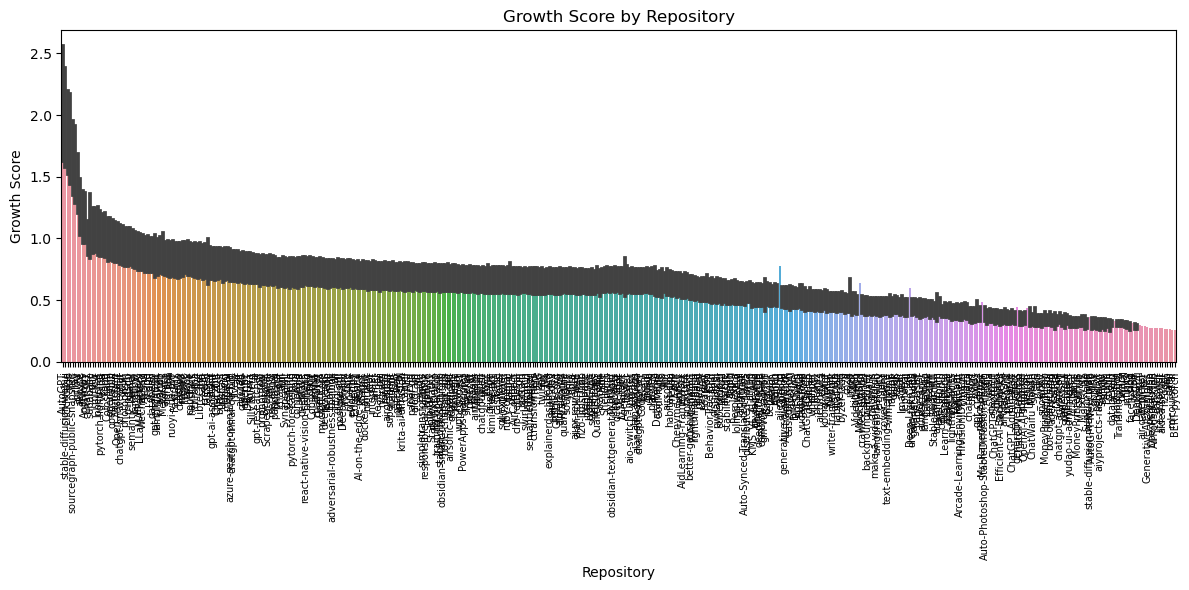

In [114]:
import seaborn as sns


df_filtered = df_main[df_main['growth_score'] > 0.25]

# Set the figure size
plt.figure(figsize=(12, 6))

# Bar plot showing growth_score for each repository
sns.barplot(x='repo_name', y='growth_score', data=df_filtered.sort_values(by='growth_score', ascending=False))

# Rotate x-axis labels for readability
plt.xticks(rotation=90, size=7)

# Add labels and title
plt.xlabel('Repository')
plt.ylabel('Growth Score')
plt.title('Growth Score by Repository')

# Show the plot
plt.tight_layout()
plt.show()

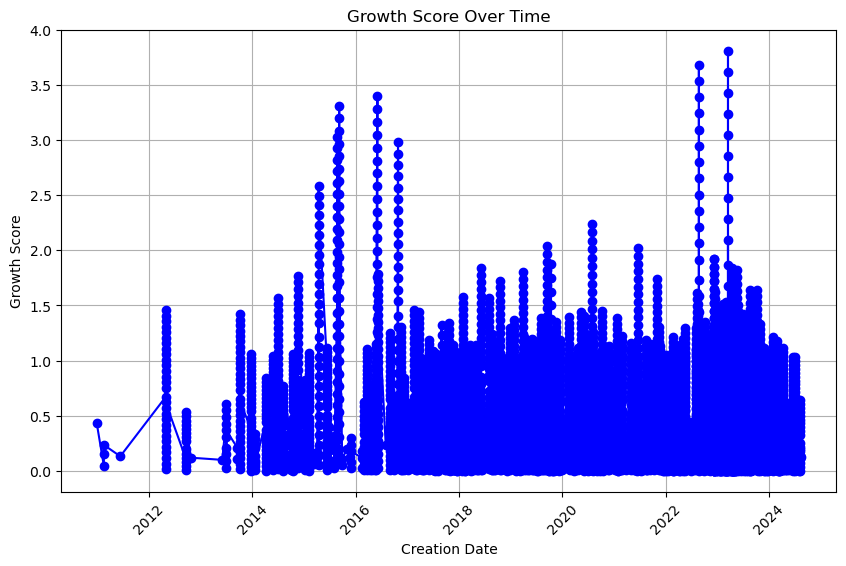

In [115]:
# Plot the growth score

# Sort the DataFrame by creation date to plot correctly
df_main = df_main.sort_values(by='creation_date')

# Plot growth_score over time
plt.figure(figsize=(10, 6))
plt.plot(df_main['creation_date'], df_main['growth_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Creation Date')
plt.ylabel('Growth Score')
plt.title('Growth Score Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

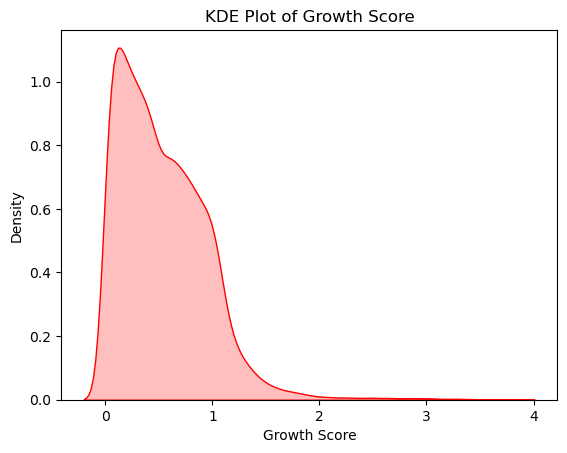

In [116]:
sns.kdeplot(df_main['growth_score'], shade=True, color="r")
plt.title('KDE Plot of Growth Score')
plt.xlabel('Growth Score')
plt.ylabel('Density')
plt.show()

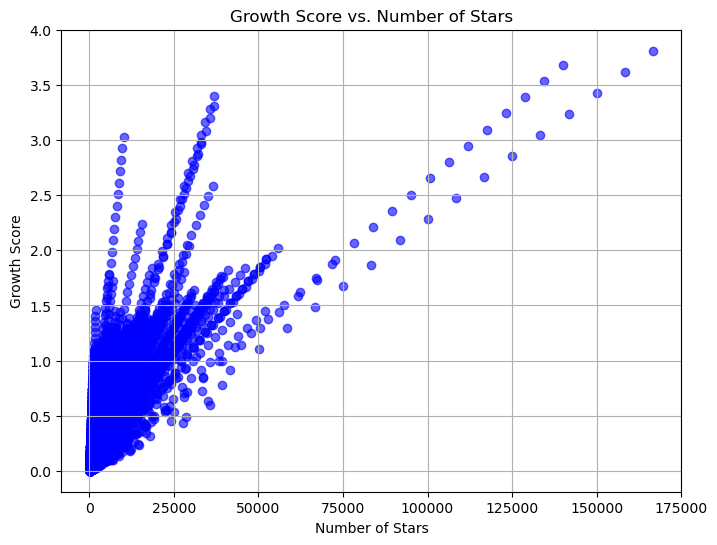

In [117]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_stars'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Stars')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Stars')

plt.grid(True)
plt.show()

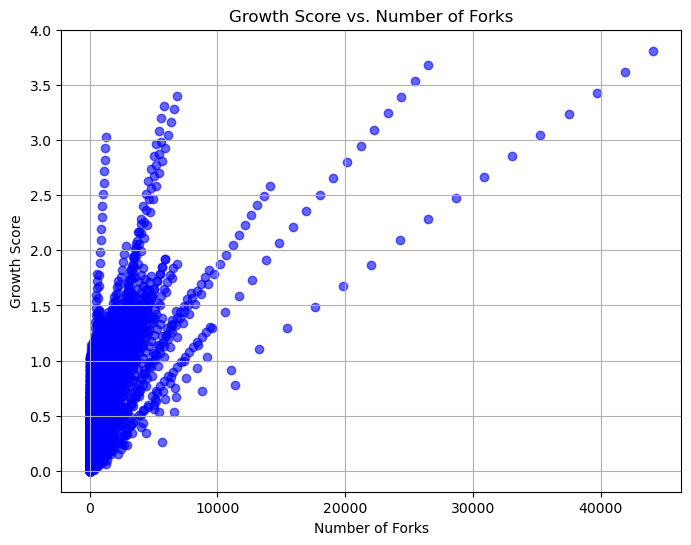

In [118]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_forks'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Forks')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Forks')

plt.grid(True)
plt.show()

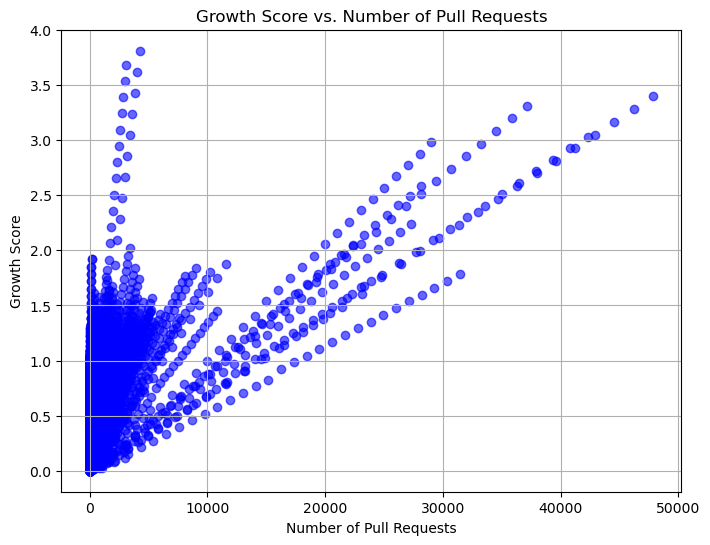

In [119]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_pull_requests'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Pull Requests')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Pull Requests')

plt.grid(True)
plt.show()

In [120]:
df_main = convert_topics_to_embeddings(df_main)
df_main.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles.hanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,org_name,repo_name,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,...,374,375,376,377,378,379,380,381,382,383
9999,lutzroeder,netron,2010-12-26 12:53:43+00:00,2024-09-21 02:09:29+00:00,2,23,228,27620,2747,27620,...,0.005798,0.025285,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846
4033,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,2023-08-17 21:10:54+00:00,1,7,1041,1105,315,1105,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910
4192,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,2023-09-06 06:12:48+00:00,3,15,2081,2211,629,2211,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910
4193,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,2023-09-06 06:13:40+00:00,4,22,3122,3316,944,3316,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910
24,lrsjng,h5ai,2011-06-11 16:53:41+00:00,2015-04-10 12:27:59+00:00,1,233,144,5521,588,5521,...,0.066473,0.075378,0.030308,-0.012484,0.028993,0.008592,0.055743,-0.000054,0.008042,0.068230


I want also to introduce 2 new features `repo_age_days` and `days_since_last_release`

In [121]:
df_main = add_repo_age_days_col(df_main)
df_main = add_days_since_last_release_col(df_main)

df_main.head()

,org_name,repo_name,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
9999,lutzroeder,netron,2024-09-21 02:09:29+00:00,2,23,228,27620,2747,27620,0.437228,...,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846,5018,1
4033,apache,incubator-kie-optaplanner,2023-08-17 21:10:54+00:00,1,7,1041,1105,315,1105,0.043116,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4967,401
4192,apache,incubator-kie-optaplanner,2023-09-06 06:12:48+00:00,3,15,2081,2211,629,2211,0.155880,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4967,381
4193,apache,incubator-kie-optaplanner,2023-09-06 06:13:40+00:00,4,22,3122,3316,944,3316,0.233983,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4967,381
24,lrsjng,h5ai,2015-04-10 12:27:59+00:00,1,233,144,5521,588,5521,0.131064,...,0.030308,-0.012484,0.028993,0.008592,0.055743,-0.000054,0.008042,0.068230,4851,3452


<Axes: xlabel='growth_score'>

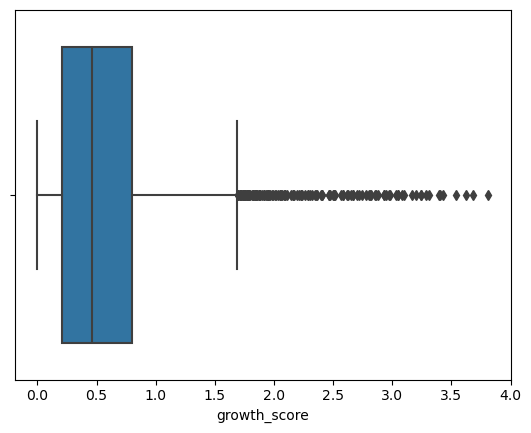

In [122]:
# Checking for outliers

sns.boxplot(x=df_main['growth_score'])

In [123]:
import numpy as np

def detect_outliers_z_score(df, column):
    threshold = 2.8
    mean = np.mean(df[column])
    std = np.std(df[column])
    z_scores = (df[column] - mean) / std
    return df[np.abs(z_scores) > threshold]

# Detect outliers in the 'growth_score' column
outliers = detect_outliers_z_score(df_main, 'growth_score')
print(outliers)

                   org_name  repo_name              release_date  \
9631                   Kong       kong 2024-09-11 09:19:15+00:00   
6394                 apache    airflow 2024-04-08 12:11:00+00:00   
7681                 apache    airflow 2024-06-19 00:26:03+00:00   
8220                 apache    airflow 2024-07-16 11:30:52+00:00   
7499                 apache    airflow 2024-06-10 10:58:26+00:00   
...                     ...        ...                       ...   
3533   Significant-Gravitas    AutoGPT 2023-06-19 20:45:18+00:00   
9699             langgenius       dify 2024-09-13 05:45:51+00:00   
9966             langgenius       dify 2024-09-20 10:25:46+00:00   
10018               lobehub  lobe-chat 2024-09-21 17:08:51+00:00   
10010               lobehub  lobe-chat 2024-09-21 09:57:23+00:00   

       num_releases  num_open_issues  num_pull_requests  num_stars  num_forks  \
9631             30              132               8085      38898       4778   
6394             22  

In [124]:
# Remove outliers detected by the IQR method
df_cleaned = df_main[~df_main.index.isin(outliers.index)]

<Axes: xlabel='growth_score'>

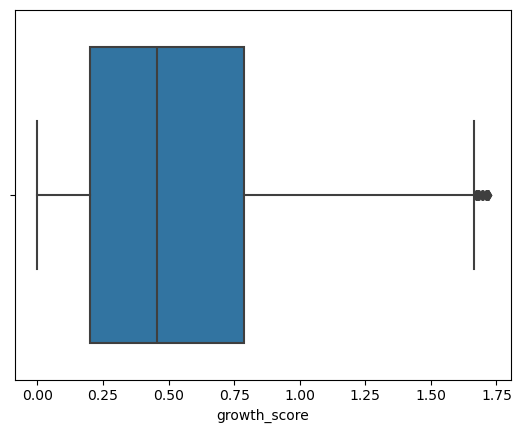

In [125]:
sns.boxplot(x=df_cleaned['growth_score'])

## Train & Testing

In [126]:
df_cleaned = indexify_release_dates(df_cleaned)
df_cleaned.head()

,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
release_date,,,,,,,,,,,,,,,,,,,,,
2013-08-09 19:12:50+00:00,vim-airline,vim-airline,1,4,85,1775,110,1775,0.025903,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4101,4061
2013-08-12 22:07:03+00:00,vim-airline,vim-airline,2,9,171,3551,221,3551,0.087058,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4101,4058
2013-08-26 17:01:52+00:00,vim-airline,vim-airline,3,13,256,5326,331,5326,0.147947,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4101,4044
2013-09-09 14:19:37+00:00,vim-airline,vim-airline,4,18,341,7102,441,7102,0.209058,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4101,4030
2013-10-10 17:59:55+00:00,vim-airline,vim-airline,6,22,426,8877,552,8877,0.304453,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4101,3999


## Timeseries Analysis

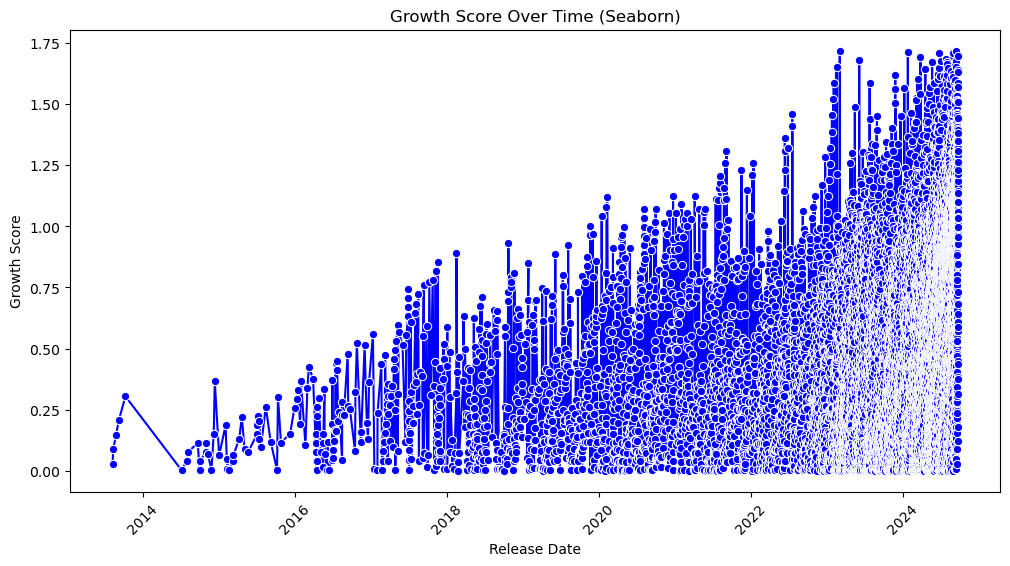

In [127]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_cleaned.index, y=df_cleaned['growth_score'], marker='o', color='b')
plt.title('Growth Score Over Time (Seaborn)')
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.xticks(rotation=45)
plt.show()

In [128]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df_cleaned['growth_score'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.072303132905917
p-value: 1.5932698884476474e-05


The data is stationary:
-  the ADF statistic of -8.96 is quite negative, which strongly suggests that your time series data is stationary.
- Since the p-value is much lower than the usual significance level of 0.05, we can reject the null hypothesis that the data is non-stationary. This confirms that your data is stationary.

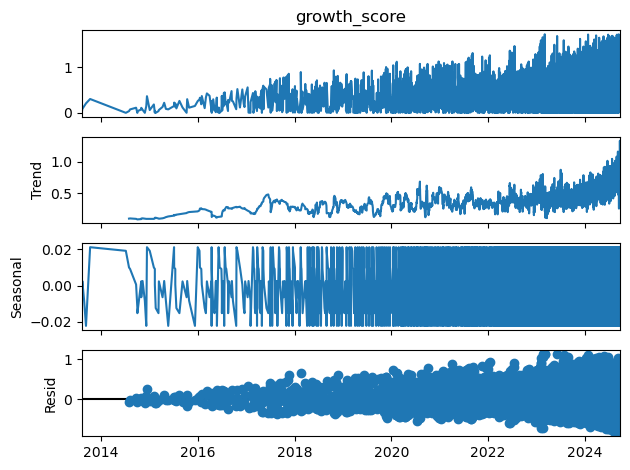

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_cleaned['growth_score'], model='additive', period=12)

# Plot the decomposed components
decomposition.plot()
plt.show()

In [130]:
print(release_counts.describe()) 

                     count       mean       std  min   25%   50%    75%   max
repo_name                                                                    
AElf                  29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
AGiXT                 29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
AI                     1.0   2.000000       NaN  2.0  2.00   2.0   2.00   2.0
AI-Blocks             10.0   6.100000  3.478505  1.0  3.25   6.5   8.75  11.0
AI-Lossless-Zoomer     1.0   2.000000       NaN  2.0  2.00   2.0   2.00   2.0
...                    ...        ...       ...  ...   ...   ...    ...   ...
yomo                  29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
yudao-cloud           13.0   7.538462  4.351540  1.0  4.00   8.0  11.00  14.0
yudao-ui-admin-vue3   10.0   6.100000  3.478505  1.0  3.25   6.5   8.75  11.0
zenml                 29.0  15.517241  8.958718  1.0  8.00  16.0  23.00  30.0
zep                   29.0  15.517241  8.958718  1.0  8.00  16.0

In [131]:
# Since 25% of repositories have 5 releases or fewer, I'll create 4 lag features. Otherwise a higher number will lead to lots of NaN values.

df_cleaned_with_lag = add_lag_features_based_on_target(df_cleaned)

df_cleaned_with_lag.head()

,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,380,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4
release_date,,,,,,,,,,,,,,,,,,,,,
2013-10-10 17:59:55+00:00,vim-airline,vim-airline,6,22,426,8877,552,8877,0.304453,0.041241,...,0.009842,0.005516,0.054387,0.027533,4101,3999,0.209058,0.147947,0.087058,0.025903
2014-07-07 08:16:11+00:00,aio-libs-abandoned,aioredis-py,1,3,37,82,12,82,0.002156,-0.051876,...,0.009335,0.051719,0.054389,0.041278,3772,3729,0.304453,0.209058,0.147947,0.087058
2014-07-31 07:52:08+00:00,aio-libs-abandoned,aioredis-py,2,7,74,164,24,164,0.039508,-0.051876,...,0.009335,0.051719,0.054389,0.041278,3772,3705,0.002156,0.304453,0.209058,0.147947
2014-08-08 07:51:11+00:00,aio-libs-abandoned,aioredis-py,3,10,112,246,36,246,0.076672,-0.051876,...,0.009335,0.051719,0.054389,0.041278,3772,3697,0.039508,0.002156,0.304453,0.209058
2014-09-22 19:50:09+00:00,aio-libs-abandoned,aioredis-py,4,14,149,328,48,328,0.114024,-0.051876,...,0.009335,0.051719,0.054389,0.041278,3772,3652,0.076672,0.039508,0.002156,0.304453


In [132]:
# Remove no-longer needed features
df_cleaned_with_lag = df_cleaned_with_lag.drop(columns=['org_name', 'repo_name'])

df_cleaned_with_lag.head()

,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,1,2,...,380,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4
release_date,,,,,,,,,,,,,,,,,,,,,
2013-10-10 17:59:55+00:00,6,22,426,8877,552,8877,0.304453,0.041241,-0.050747,-0.080221,...,0.009842,0.005516,0.054387,0.027533,4101,3999,0.209058,0.147947,0.087058,0.025903
2014-07-07 08:16:11+00:00,1,3,37,82,12,82,0.002156,-0.051876,-0.103019,-0.099194,...,0.009335,0.051719,0.054389,0.041278,3772,3729,0.304453,0.209058,0.147947,0.087058
2014-07-31 07:52:08+00:00,2,7,74,164,24,164,0.039508,-0.051876,-0.103019,-0.099194,...,0.009335,0.051719,0.054389,0.041278,3772,3705,0.002156,0.304453,0.209058,0.147947
2014-08-08 07:51:11+00:00,3,10,112,246,36,246,0.076672,-0.051876,-0.103019,-0.099194,...,0.009335,0.051719,0.054389,0.041278,3772,3697,0.039508,0.002156,0.304453,0.209058
2014-09-22 19:50:09+00:00,4,14,149,328,48,328,0.114024,-0.051876,-0.103019,-0.099194,...,0.009335,0.051719,0.054389,0.041278,3772,3652,0.076672,0.039508,0.002156,0.304453


In [133]:
# Re-transforming the target variable after performing residual analysis after model training and prediction
df_cleaned_with_lag['growth_score'] = np.log1p(df_cleaned_with_lag['growth_score'])
# df_cleaned_with_lag['growth_score'] = np.sqrt(df_cleaned_with_lag['growth_score'])

In [134]:
# Define the features and target
X = df_cleaned_with_lag.drop(columns=['growth_score']).values
y = df_cleaned_with_lag['growth_score'].values


In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [136]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import joblib

# Initialize the scaler
scaler_X = MinMaxScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler_X.fit_transform(X_train)

joblib.dump(scaler_X, '../models/final_input_scaler.pkl')

# Apply the same scaler to the test data
X_test_scaled = scaler_X.transform(X_test)

# If you want to scale y as well, do it the same way
scaler_y = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

joblib.dump(scaler_y, '../models/final_target_scaler.pkl')

print(X_train_scaled.shape)

(7912, 396)


In [137]:
# X_train_scaled, X_test_scaled = scale_final_data(X_train=X_train, X_test=X_test)

Explained variance ratio by PCA: 0.96


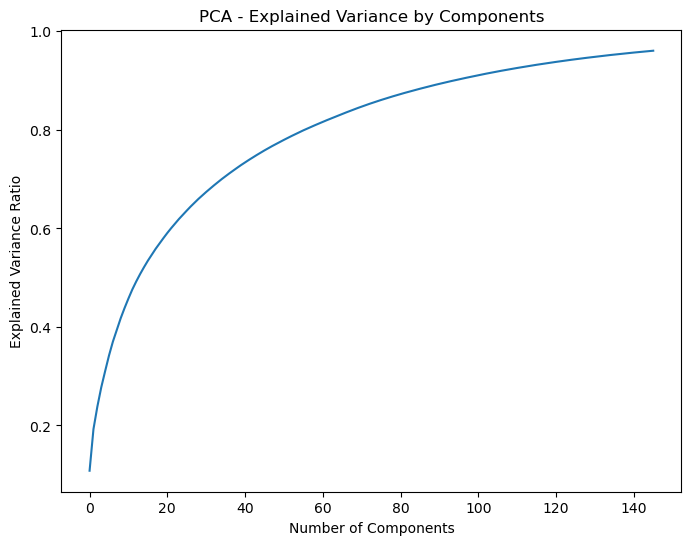

(7912, 146)


In [230]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Set the number of components to retain (e.g., 95% of variance)
pca = PCA(n_components=0.96)

# Fit PCA on training data and transform both train and test sets
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
joblib.dump(pca, '../models/pca_model.pkl')

print(f'Explained variance ratio by PCA: {np.sum(pca.explained_variance_ratio_):.2f}')

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance by Components')
plt.show()

print(X_train_scaled_pca.shape)

In [231]:
n_timesteps = 5
n_features_pca = X_train_scaled_pca.shape[1]

In [232]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(X_train_scaled_pca, y_train_scaled, length=n_timesteps, batch_size=32)
test_generator = TimeseriesGenerator(X_test_scaled_pca, y_test_scaled, length=n_timesteps, batch_size=32)

In [304]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape, learning_rate=1e-4, lstm_units=160, dropout_rate=0.5):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Output layer (Dense layer with 1 unit for regression task)
    model.add(Dense(1))

    # Compile the model with Adam optimizer and a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [305]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the LSTM model

input_shape = (n_timesteps, n_features_pca)

model = create_lstm_model(input_shape=input_shape, learning_rate=1e-6, lstm_units=128, dropout_rate=0.5)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/best_rnn_model.keras', save_best_only=True, monitor='val_loss')


history = model.fit(train_generator, epochs=200, batch_size=32, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

input_shape


Epoch 1/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2126 - val_loss: 0.2039
Epoch 2/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2172 - val_loss: 0.2016
Epoch 3/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2153 - val_loss: 0.1993
Epoch 4/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2105 - val_loss: 0.1971
Epoch 5/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2091 - val_loss: 0.1949
Epoch 6/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2058 - val_loss: 0.1927
Epoch 7/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2053 - val_loss: 0.1906
Epoch 8/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2031 - val_loss: 0.1884
Epoch 9/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2000 - val_loss: 0.1863
Epoch 10/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1950 - val_loss: 0.1842
Epoch 11/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1974 - val_loss: 0.1821
Epoch 12/200
248/248 ━━━━━━━━━━━━━━━━━━━━

(5, 146)

In [306]:
from tensorflow.keras.models import load_model

model = load_model('../models/best_rnn_model.keras')

In [307]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 128)            │       140,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,789 (1.61 MB)

 Trainable params: 140,929 (550.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 281,860 (1.08 MB)

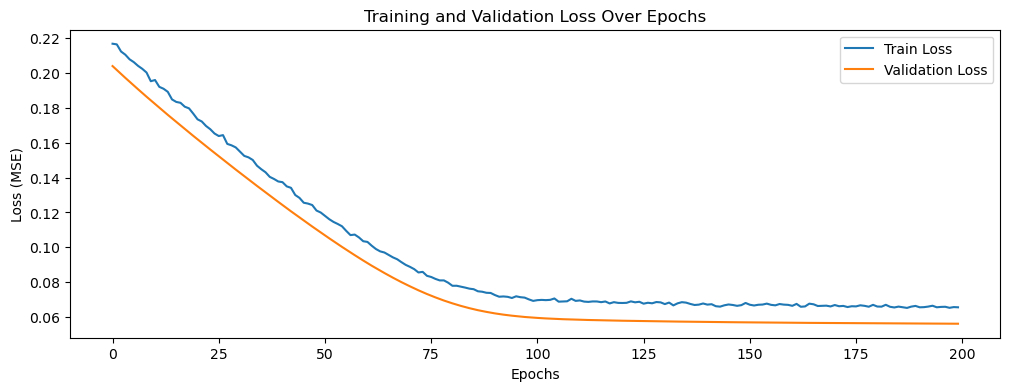

In [308]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [309]:
test_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0547
Test Loss: 0.05623936280608177


In [310]:
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Predict scaled values
y_pred_scaled = model.predict(test_generator)

# y_pred_scaled_reshaped = y_pred_scaled.reshape(-1, 1)

# Inverse transform the predicted values back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Initialize a list for the actual values
y_actual = []

# Extract actual values from test_generator
for i in range(len(test_generator)):
    _, target = test_generator[i]  # target is the true y values for the batch
    y_actual.append(target)

# Flatten the array to match y_pred
y_actual = np.concatenate(y_actual).reshape(-1)  

# Flatten the predicted values
y_pred = y_pred.reshape(-1)

# Print one pair of actual vs predicted for verification
print(f'actual: {y_actual[2]}', f' | predicted: {y_pred[2]}')



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
actual: 0.25701774722060633  | predicted: 0.41589123010635376


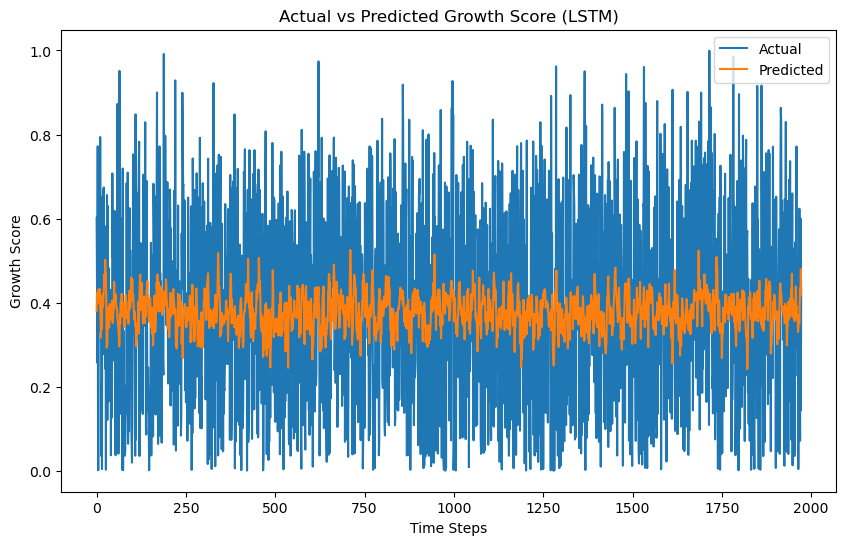

In [311]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Growth Score')
plt.title('Actual vs Predicted Growth Score (LSTM)')
plt.legend()

plt.show()

Considering the model is overpredicting. For this reason it would be important to conduct a residual analysis to better understand the cause of this overprediction.

In [312]:
residuals = y_actual - y_pred
print(residuals)

[ 0.22155603  0.03954983 -0.15887348 ...  0.18359502 -0.33565582
 -0.00261577]


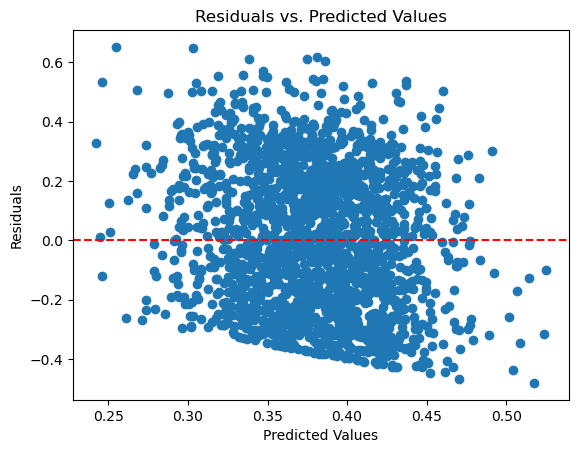

In [313]:
import matplotlib.pyplot as plt

# Residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Most of the points are below 0 indicating that the model is not a good fit, suggesting that there's a systematic error in the data.
There is a slight downward trend in the residuals, indicating that the errors are not randomly distributed around 0. This could suggest that there is some non-linearity in the relationship between the input and the target. 

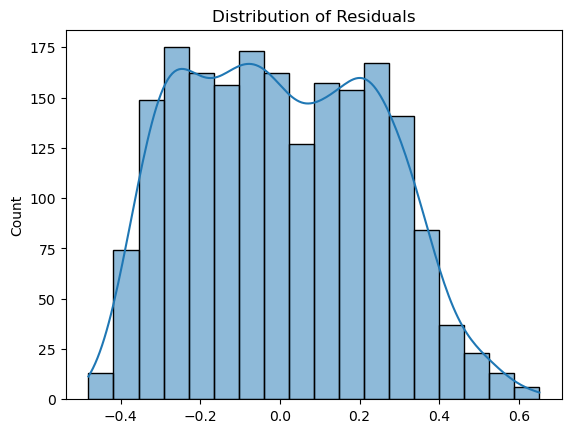

In [314]:
import seaborn as sns

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

If residuals follow a bell-shaped curve centered around zero, the model’s errors are likely normally distributed.

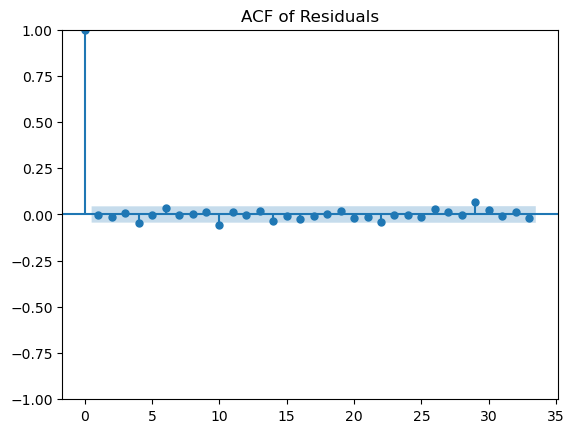

In [315]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

If the ACF plot shows significant spikes, it means the residuals are autocorrelated, suggesting the model is missing important temporal patterns.

In [316]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.056238225794292745
MAE: 0.202224779562539


In [317]:
n_forecast_steps = 12  # Number of steps to forecast
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Perform the forecasting
forecasted_values =  forecast_growth(
    model=model, 
    initial_data=X_test_scaled_pca, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=6,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecasted Growth Scores: [0.42398486 0.4086933  0.39821884 0.4053672  0.4068798  0.42701885
 0.4210048  0.4209494  0.4211628  0.42154816 0.42181712 0.4220581 ]


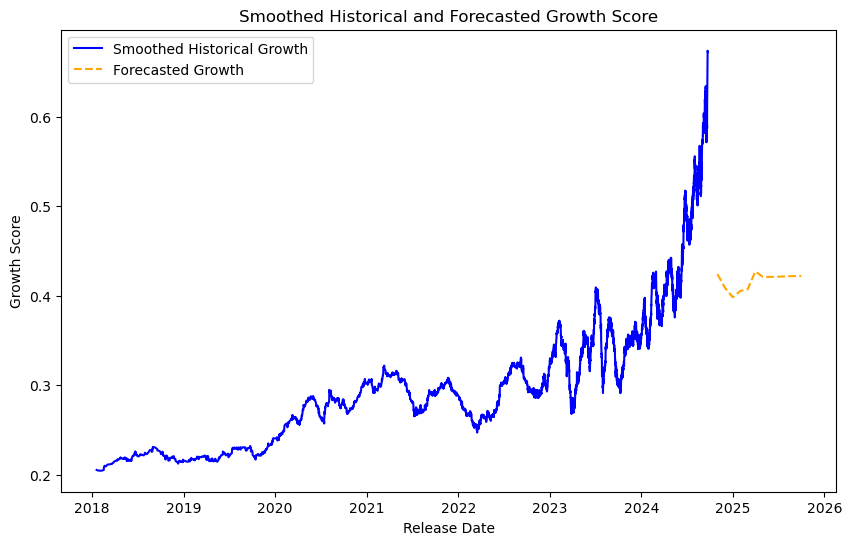

In [318]:
# Ensure the index is in datetime format (if not already)
df_cleaned_with_lag.index = pd.to_datetime(df_cleaned_with_lag.index)

# Historical data: Plot the actual release dates with the growth score
historical_growth = df_cleaned_with_lag['growth_score']

# Generate future dates for the forecasted values based on the release_date index
# If you are forecasting 'n_steps' into the future (assuming monthly intervals)
forecasted_dates = pd.date_range(start=df_cleaned_with_lag.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]


# Apply a rolling average to smooth historical data (using a window of 10)
df_cleaned_with_lag['smoothed_growth_score'] = df_cleaned_with_lag['growth_score'].rolling(window=200).mean()


# Plot the smoothed historical growth score and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned_with_lag.index, df_cleaned_with_lag['smoothed_growth_score'], color='blue', label='Smoothed Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')

plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()